In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import re

import warnings
warnings.filterwarnings("ignore")

In [8]:
# import os
# os.environ['KERAS_BACKEND'] = 'tensorflow'
# from keras.preprocessing.sequence import pad_sequences

## Load Data

In [9]:
data = pd.read_csv("data/refugee_coca_foranalysis.csv")
#df = df_raw[['text','genre','year']]
#df.rename(columns={'text':'sentence', 'genre':'label'}, inplace=True)

In [10]:
#5-year periods
def get_period(year, startyr, endyr, n=5):
    period_start = []
    for i in range(startyr, endyr+1, n):
        period_start.append(i)
    for index, p in enumerate(period_start):
        if year >= p:
            period = index
            continue
        else:
            break
    return period  
    
data['period'] = data['year'].apply(lambda x: get_period(x, 1991, 2015, n=5) if x>=1991 else 0)

In [11]:
# Add label
unique_sources = list(data.source.apply(lambda x: re.split("_|: | ", x)[0]).unique())
len(unique_sources)

# Write a function that let us conveniently label ideology: Left, Neutral, Right
media_ideology = {}

def label_ideology(media_title, ideology, media_ideology = media_ideology):
    media_ideology[media_title] = ideology
    
label_ideology('Money', 'Neutral')
label_ideology('MotherEarth', 'Neutral')
label_ideology('MotherJones', 'Left')
label_ideology('AmHeritage', 'Neutral')
label_ideology('AmSpect', 'Right')
label_ideology('Forbes', 'Right')
label_ideology('NatlReview', 'Right')
label_ideology('Newsweek', 'Left')
label_ideology('ScienceNews', 'Neutral')
label_ideology('Smithsonian', 'Neutral')
label_ideology('USNWR', 'Left')
label_ideology('WashMonth', 'Left')
label_ideology('ChangingTimes', 'Right')
label_ideology('HistoryToday', 'Neutral')
label_ideology('Omni', 'Neutral')
label_ideology('Wilderness', 'Neutral')
label_ideology('TIME', 'Left')
label_ideology('NatlParks', 'Neutral')
label_ideology('AmerArtist', 'Neutral')
label_ideology('RollingStone', 'Left')
label_ideology('Americas', 'Neutral')
label_ideology('SportsIll', 'Neutral')
label_ideology('Ms', 'Left')
label_ideology('PopScience', 'Neutral')
label_ideology('Futurist', 'Neutral')
label_ideology('HarpersMag', 'Left')
label_ideology('Fortune', 'Right')
label_ideology('USAToday', 'Left')
label_ideology('America', 'Left')
label_ideology('ChristCentury', 'Right')
label_ideology('People', 'Left')
label_ideology('Jet', 'Left')
label_ideology('Aging', 'Neutral')
label_ideology('Horticulture', 'Neutral')
label_ideology('NewRepublic', 'Left')
label_ideology('Conservation', 'Left')
label_ideology('NaturalHist', 'Neutral')
label_ideology('Atlantic', 'Left')
label_ideology('Inc.', 'Neutral')
label_ideology('ChildrenToday', 'Neutral')
label_ideology('Ebony', 'Left')
label_ideology('ConsumResrch', 'Neutral')
label_ideology('SatEvenPost', 'Neutral')
label_ideology('ChristToday', 'Right')
label_ideology('Backpacker', 'Neutral')
label_ideology('AmericanCraft', 'Neutral')
label_ideology('ArtAmerica', 'Neutral')
label_ideology('SportingNews', 'Neutral')
label_ideology('MensHealth', 'Neutral')
label_ideology('Antiques', 'Neutral')
label_ideology('Parenting', 'Neutral')
label_ideology('Essence', 'Neutral')
label_ideology('Environmental', 'Neutral')
label_ideology('USCatholic', 'Right')
label_ideology('MilitaryHist', 'Neutral')
label_ideology('PsychToday', 'Neutral')
label_ideology('Cosmopolitan', 'Left')
label_ideology('Redbook', 'Neutral')
label_ideology('Bazaar', 'Left')
label_ideology('ChildDigest', 'Neutral')
label_ideology('Bicycling', 'Neutral')
label_ideology('Shape', 'Neutral')
label_ideology('NatGeog', 'Neutral')
label_ideology('Entertainment', 'Neutral')
label_ideology('Astronomy', 'Neutral')
label_ideology('TownCountry', 'Neutral')
label_ideology('TotalHealth', 'Neutral')
label_ideology('Esquire', 'Left')
label_ideology('FieldStream', 'Neutral')
label_ideology('TechReview', 'Neutral')
label_ideology('CountryLiving', 'Neutral')
label_ideology('VegTimes', 'Neutral')
label_ideology('SouthernLiv', 'Neutral')
label_ideology('Skiing', 'Neutral')
label_ideology('ConsumRep', 'Neutral')
label_ideology('Sunset', 'Neutral')
label_ideology('HarpersBazaar', 'Neutral')
label_ideology('AmericanSpectator', 'Right')
label_ideology('GoodHousekeeping', 'Neutral')
label_ideology('PopMech', 'Neutral')
label_ideology('MHQTheQuarterly', 'Neutral')
label_ideology('TodaysParent', 'Neutral')
label_ideology('NationalGeographic', 'Neutral')
label_ideology('EEnvironmental', 'Neutral')
label_ideology('ParentingEarly', 'Neutral')
label_ideology('ABC', 'Left')
label_ideology('CNN', 'Left')
label_ideology('PBS', 'Left')
label_ideology('CBS', 'Left')
label_ideology('Ind', 'Left')
label_ideology('NPR', 'Left')
label_ideology('NBC', 'Left')
label_ideology('Fox', 'Right')
label_ideology('MSNBC', 'Left')
label_ideology('NYTimes', 'Left')
label_ideology('CSMonitor', 'Neutral')
label_ideology('AssocPress', 'Neutral')
label_ideology('WashPost', 'Left')
label_ideology('SanFranChron', 'Left')
label_ideology('Atlanta', 'Left') #Atlanta Journal Constitution
label_ideology('Houston', 'Left') #Houston Chronicle
label_ideology('Chicago', 'Left') #Chicago Sun-Times
label_ideology('Denver', 'Left') #Denver Post
label_ideology('GolfMag', 'Neutral')
label_ideology('NewStatesman', 'Left')
label_ideology('Austin', 'Left') #Austin American Statesman
label_ideology('STLouis', 'Left') #St Louis Post_Dispatch
label_ideology('Pittsburgh', 'Right') #Pittsburgh Post-Gazette
label_ideology('OrangeCR', 'Right') #Orange County Register

#add political leaning label
def add_ideology(x, media_ideology=media_ideology):
    try_split = re.split("_|: | ",x)
    if len(try_split)>1:
        x = try_split[0]
    if x in media_ideology:
        return media_ideology[x]
    else:
        print('{} does not exists'.format(x))

data["ideology"] = data['source'].apply(add_ideology)

In [17]:
data['label'] = data['label'].mask(data['ideology']=='Left',0)
data['label'] = data['label'].mask(data['ideology']=='Right',1)

In [19]:
data = data[data['ideology']!='Neutral']

In [21]:
data = data[['text','label','period']]
data.rename(columns={'text':'sentence'}, inplace=True)

In [22]:
data

,sentence,label,period
3,section : movements from socialist to republi...,0,0
4,inside a dusty cement-block house with worn ...,0,0
6,even if saddam hussein fails to get his way ...,1,0
7,section : spectator 's journal dateline : li...,1,0
8,soviet jewry is giving israel new life -- bu...,1,0
...,...,...,...
3987,"!kelly-mcevers# oh , thanks , nice to meet yo...",0,4
3988,!margaret-warner# and i 'm margaret warner . ...,0,4
3989,"!judy-woodruff# the syrian opposition , u.n ....",0,4
3990,!charlie-rose : good morning . it is friday d...,0,4


In [24]:
df_test = data[data.period==4]
df_train = data[data.period!=4]

In [25]:
df_train.sample(10)

,sentence,label,period
871,!sen-robert-dole- : but i think some of these...,0,0
2681,"little sara , nearly 5 , gets to watch her b...",0,1
2151,when sharon hudson returned from baton rouge...,0,0
2036,women 's strength editor i am intrigued by...,0,0
153,go on the offensive there 's such a power ba...,0,0
3151,the baby carrots at beirut 's tony duo caf r...,0,3
2567,"the stockholm of america , this city of lute...",0,1
1594,"10:00-11:00 am , this is morning edition from...",0,2
190,the symbolism in the drawing at left is tradi...,1,0
695,two church members came in to talk to me on t...,1,3


In [26]:
df_test.sample(10)

,sentence,label,period
3784,three quarters of undocumented immigrants in ...,1,4
3501,from its headquarters in a longmont industria...,0,4
3853,"when my husband and i travel , we often follo...",0,4
3603,: feature why do some people cope with trauma...,0,4
3790,"margin notes # this winter , as another blizz...",1,4
3402,"saydnaya , syria -- abu elias sat beneath the...",0,4
3818,"duma , west bank -- early one recent morning ...",0,4
3732,!judy-woodruff# a chilling new warning today ...,0,4
762,""" what we have are two competing narratives ,...",0,4
3762,when clinton became secretary of state and sa...,1,4


## Preparation

In [28]:
# Create sentence and label lists
sentences = df_train.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df_train.label.values

In [29]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'section', ':', 'movements', 'from', 'socialist', 'to', 'republicans', ',', 'a', 'generation', 'of', 'student', 'activists', 'test', 'the', 'limits', 'of', 'volunteer', '##ism', '.', 'university', 'of', 'houston', 'student', 'lloyd', 'jacobs', '##on', 'was', 'organizing', 'for', 'a', 'sleep', '-', 'in', 'outside', 'a', 'local', 'homeless', 'shelter', 'and', 'invited', 'the', 'head', 'of', 'the', 'campus', 'college', 'republicans', 'to', 'join', 'in', '.', '"', 'do', 'n', "'", 't', 'you', 'want', 'to', 'be', 'part', 'of', 'bush', "'", 's', 'thousand', 'points', 'of', 'light', '?', '"', 'jacobs', '##on', 'asked', ',', 'and', 'quickly', 'got', 'the', 'student', 'to', 'agree', '.', 'others', 'in', 'the', 'republican', 'group', 'hesitated', ',', 'but', 'reluctantly', 'came', 'along', '.', 'jacobs', '##on', 'next', 'enlisted', 'the', 'college', 'democrats', ':', '"', 'they', "'", 're', 'participating', '.', 'are', 'n', "'", 't', 'you', 'going', 'to', 'a

In [29]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [30]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [31]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [32]:
print(len(df), len(input_ids), len(attention_masks))

3628 3628 3628


In [33]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=2020, test_size=0.1)

### LSTM

In [34]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

vocab_in_size = tokenizer.vocab_size
embedding_dim = 32
unit = 100
no_labels = len(np.unique(train_labels))
batch_size = 32

In [35]:
# Using Softmax activation
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm.add(LSTM(unit))
model_lstm.add(Dense(no_labels, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 128, 32)           976704    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 1,030,207
Trainable params: 1,030,207
Non-trainable params: 0
_________________________________________________________________


In [36]:
history_lstm = model_lstm.fit(train_inputs, train_labels, 
                              epochs=10,batch_size=batch_size)

Epoch 1/10
3265/3265 [==============================] - 8s 2ms/step - loss: 0.8874 - accuracy: 0.5568
Epoch 2/10
3265/3265 [==============================] - 9s 3ms/step - loss: 0.6319 - accuracy: 0.7179
Epoch 3/10
3265/3265 [==============================] - 9s 3ms/step - loss: 0.8407 - accuracy: 0.6153
Epoch 4/10
3265/3265 [==============================] - 9s 3ms/step - loss: 1.0058 - accuracy: 0.5994
Epoch 5/10
3265/3265 [==============================] - 9s 3ms/step - loss: 0.5916 - accuracy: 0.7776
Epoch 6/10
3265/3265 [==============================] - 9s 3ms/step - loss: 0.4793 - accuracy: 0.8257
Epoch 7/10
3265/3265 [==============================] - 9s 3ms/step - loss: 0.2207 - accuracy: 0.9332
Epoch 8/10
3265/3265 [==============================] - 9s 3ms/step - loss: 0.2362 - accuracy: 0.9259
Epoch 9/10
3265/3265 [==============================] - 9s 3ms/step - loss: 0.3261 - accuracy: 0.8907
Epoch 10/10
3265/3265 [==============================] - 9s 3ms/step - loss: 0.403

In [37]:
# Using Sigmoid Activation
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm.add(LSTM(unit))
model_lstm.add(Dense(no_labels, activation='sigmoid'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 128, 32)           976704    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 303       
Total params: 1,030,207
Trainable params: 1,030,207
Non-trainable params: 0
_________________________________________________________________


In [38]:
history_lstm = model_lstm.fit(train_inputs, train_labels, 
                              epochs=10,batch_size=batch_size)

Epoch 1/10
3265/3265 [==============================] - 8s 2ms/step - loss: 1.0631 - accuracy: 0.4413
Epoch 2/10
3265/3265 [==============================] - 8s 3ms/step - loss: 0.7046 - accuracy: 0.6772
Epoch 3/10
3265/3265 [==============================] - 8s 3ms/step - loss: 0.9945 - accuracy: 0.5467
Epoch 4/10
3265/3265 [==============================] - 9s 3ms/step - loss: 0.8929 - accuracy: 0.6098
Epoch 5/10
3265/3265 [==============================] - 9s 3ms/step - loss: 0.6947 - accuracy: 0.7498
Epoch 6/10
3265/3265 [==============================] - 9s 3ms/step - loss: 0.3427 - accuracy: 0.9179
Epoch 7/10
3265/3265 [==============================] - 9s 3ms/step - loss: 0.1824 - accuracy: 0.9424
Epoch 8/10
3265/3265 [==============================] - 9s 3ms/step - loss: 0.0728 - accuracy: 0.9841
Epoch 9/10
3265/3265 [==============================] - 9s 3ms/step - loss: 0.0373 - accuracy: 0.9911
Epoch 10/10
3265/3265 [==============================] - 9s 3ms/step - loss: 0.028

In [39]:
vocab_in_size = tokenizer.vocab_size
embedding_dim = 128
unit = 100
no_labels = len(np.unique(train_labels))
batch_size = 32

In [40]:
# Using Sigmoid Activation with higher embedding dimension
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm.add(LSTM(unit))
model_lstm.add(Dense(no_labels, activation='sigmoid'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 128, 128)          3906816   
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 303       
Total params: 3,998,719
Trainable params: 3,998,719
Non-trainable params: 0
_________________________________________________________________


In [41]:
history_lstm = model_lstm.fit(train_inputs, train_labels, 
                              epochs=10,batch_size=batch_size)

Epoch 1/10
3265/3265 [==============================] - 13s 4ms/step - loss: 0.8932 - accuracy: 0.5825
Epoch 2/10
3265/3265 [==============================] - 12s 4ms/step - loss: 0.6545 - accuracy: 0.7161
Epoch 3/10
3265/3265 [==============================] - 12s 4ms/step - loss: 0.4397 - accuracy: 0.8441
Epoch 4/10
3265/3265 [==============================] - 12s 4ms/step - loss: 0.2698 - accuracy: 0.9201
Epoch 5/10
3265/3265 [==============================] - 12s 4ms/step - loss: 0.2686 - accuracy: 0.9002
Epoch 6/10
3265/3265 [==============================] - 14s 4ms/step - loss: 0.1815 - accuracy: 0.9397
Epoch 7/10
3265/3265 [==============================] - 13s 4ms/step - loss: 0.1661 - accuracy: 0.9467
Epoch 8/10
3265/3265 [==============================] - 12s 4ms/step - loss: 0.0897 - accuracy: 0.9743
Epoch 9/10
3265/3265 [==============================] - 12s 4ms/step - loss: 0.0260 - accuracy: 0.9936
Epoch 10/10
3265/3265 [==============================] - 13s 4ms/step - l

### BERT

In [43]:
# Convert all of our data into torch tensors, the required datatype for our model
train_labels = train_labels.astype(np.int64)
validation_labels = validation_labels.astype(np.int64)

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [44]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [55]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
# model.cuda()

In [56]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [57]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [58]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [59]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [60]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [61]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Training Evaluation

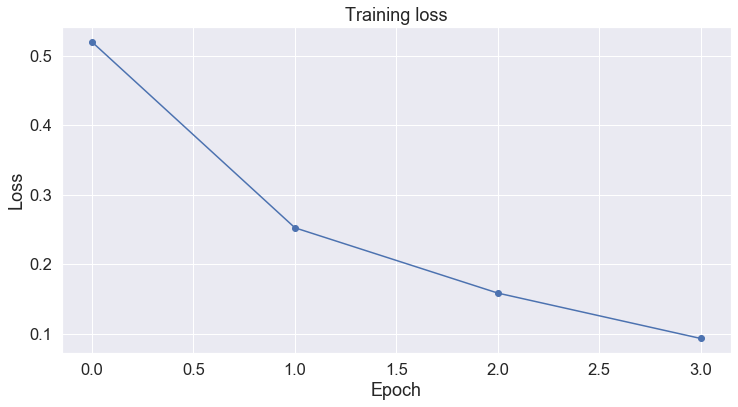

In [63]:
# From Co-Lab
loss_values = [0.5200353502069862,
 0.25253528530157887,
 0.1585460943938459,
 0.09321240230816082]

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

### Holdout Set

In [143]:
model = BertForSequenceClassification.from_pretrained("coca_refugee", num_labels=3)

In [144]:
df_test.sample(10)

,sentence,label,year
3893,"!gwen-ifill# president obama apologizes , aft...",1,2015
3714,"!gary-shteyngart# thank you , great to be her...",1,2014
3834,anas hussein holds a terrible secret . unbekn...,2,2015
3600,section : features the wave of immigrant chil...,0,2014
3670,a rising tide of refugees from three years of...,2,2014
3796,section : articles the camps in calais are a ...,0,2015
3632,the surge of tens of thousands of unaccompani...,2,2014
3676,dinaw mengestu left his native ethiopia when ...,2,2014
3821,as a student at colorado college in the late ...,2,2015
3697,"!chuck-todd , -nbc-ne# host : this sunday on ...",1,2014


In [146]:
import pandas as pd

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

# Create sentence and label lists
sentences = df_test.sentence.values
labels = df_test.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length=512
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels.astype(np.int64))

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 364



In [147]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 364 test sentences...
    DONE.


In [148]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [149]:
matthews_set

[0.0,
 0.6831300510639733,
 0.0,
 0.8408409924953906,
 0.0,
 1.0,
 0.0,
 0.8643121965600912,
 0.0,
 0.9415579458077198,
 0.0,
 0.0]

In [150]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.901


The Matthews Correlation Coefficient Model is very high for the BERT model at 0.9. Both the LSTM and BERT performed extremely well and much better than the best models in the classifiers from homework 3 at classifying text according to the genre they belong to.

## Embeddings, Context Words

We saw how a bootstrapped BERT model performed so much better than a model trained from scatch. Because BERT's method of capturing context is bidirectional, meaning that words can now have different word embedding values based on their location within a sentence. Let us use the same BERT model to capture sentence and word embeddings. 

In [85]:
from transformers import BertModel

Let's go through the sentence format for the BERT model, as well as how our vocabulary looks like. Note that you have to use the BERT tokenizer to use the BERT model because of the similar vocabulary.

In [86]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [87]:
text = "Here is the sentence I want embeddings for."
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.', '[SEP]']


BERTS model uses a WordPiece technique to do its tokenizing, as described in the paper. That's why the word embedding is split up the way it is.
A quick peek at what the voabulary looks like:

In [88]:
list(tokenizer.vocab.keys())[6000:6030]

['peninsula',
 'adults',
 'novels',
 'emerged',
 'vienna',
 'metro',
 'debuted',
 'shoes',
 'tamil',
 'songwriter',
 'meets',
 'prove',
 'beating',
 'instance',
 'heaven',
 'scared',
 'sending',
 'marks',
 'artistic',
 'passage',
 'superior',
 '03',
 'significantly',
 'shopping',
 '##tive',
 'retained',
 '##izing',
 'malaysia',
 'technique',
 'cheeks']

In [89]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indices.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


### Segment ID

BERT is trained on and expects sentence pairs, using 1s and 0s to distinguish between the two sentences. That is, for each token in “tokenized_text,” we must specify which sentence it belongs to: sentence 0 (a series of 0s) or sentence 1 (a series of 1s). For our purposes, single-sentence inputs only require a series of 1s, so we will create a vector of 1s for each token in our input sentence.

If you want to process two sentences, assign each word in the first sentence plus the ‘[SEP]’ token a 0, and all tokens of the second sentence a 1.

In [101]:
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Like we did for classification, we now convert these segments to tensors.

The embedding layer is the hidden state layer, and this is what we pick up.

In [91]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [126]:
# Load pre-trained model (weights)
model_embedding = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model_embedding.eval()

NameError: name 'BertModel' is not defined

In [103]:
output = model_embedding(tokens_tensor)

In [105]:
len(output[0][0][0]), len(output[1][0])

(768, 768)

### Understanding the Output

This kind of forward pass returns us the last layer of the net, which we will use to make our vectors. The first object returned contains the batch number, followed by each of the tokens and their vector values. The second object contains a vector value, which I suspect is the sentence vector of the tokens. 

The first index is the batch size, and our batch size is 1, so we just choose the 0th index and work with that.

In [106]:
word_embeddings, sentence_embedding = output

In [107]:
len(word_embeddings[0])

22

In [108]:
word_embeddings[0]

tensor([[-0.4964, -0.1831, -0.5231,  ..., -0.1902,  0.3738,  0.3964],
        [-0.1323, -0.2762, -0.3495,  ..., -0.4567,  0.3786, -0.1096],
        [-0.3626, -0.4002,  0.0676,  ..., -0.3207, -0.2709, -0.3004],
        ...,
        [ 0.2961, -0.2856, -0.0382,  ..., -0.6056, -0.5163,  0.2005],
        [ 0.4878, -0.0909, -0.2358,  ..., -0.0017, -0.5945, -0.2431],
        [-0.2517, -0.3519, -0.4688,  ...,  0.2500,  0.0336, -0.2627]],
       grad_fn=<SelectBackward>)

Let’s take a quick look at the range of values for a given layer and token.

You’ll find that the range is fairly similar for all layers and tokens, with the majority of values falling between [-2, 2], and a small smattering of values around -10.

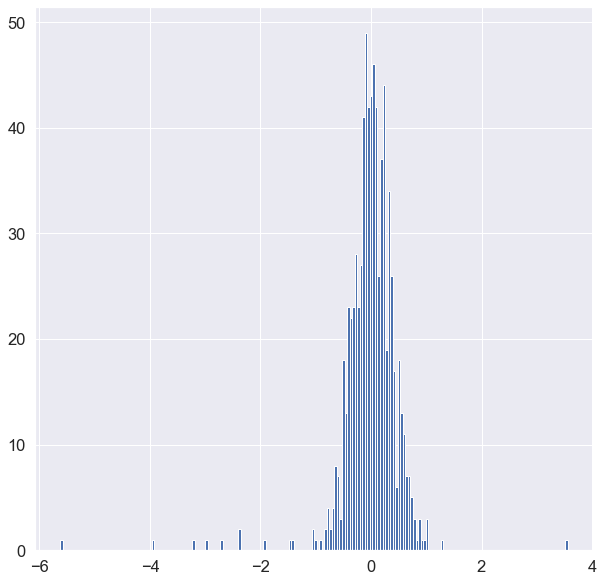

In [109]:
vec = word_embeddings[0][0]
vec = vec.detach().numpy()
# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

These values are grouped by layer - we can use the permute function to make it grouped by each individual token instead. Let us look at what the later looks like:

### Word Vectors

So each of those tokens have embedding values - let us try and compare them with each other.

In [110]:
token_vecs = []
# For each token in the sentence...
for embedding in word_embeddings[0]:
    cat_vec = embedding.detach().numpy()
    # Use `cat_vec` to represent `token`.
    token_vecs.append(cat_vec)

In [111]:
token_vecs

[array([-4.96443719e-01, -1.83083594e-01, -5.23144066e-01,  5.25868058e-01,
         5.07567704e-01,  1.63770974e-01,  2.03400254e-01,  3.17120850e-01,
        -5.31786606e-02, -1.73957109e-01,  1.56624392e-01, -2.91166574e-01,
        -4.70112741e-01,  6.43651009e-01,  1.01684801e-01,  4.04034629e-02,
        -2.23800465e-01,  4.66817468e-01,  7.84237146e-01, -2.29057610e-01,
        -1.18187532e-01, -1.04612984e-01,  2.05792308e-01,  1.56229973e-01,
        -3.35291661e-02, -1.64334267e-01, -3.00018489e-01, -9.57754403e-02,
        -9.04613286e-02,  3.83675069e-01,  5.08685671e-02,  5.76394685e-02,
        -1.03360116e-01, -8.35442245e-01,  1.45373330e-01, -3.95008624e-01,
         4.80391756e-02, -1.43011242e-01,  4.68771905e-02,  3.04918170e-01,
        -3.79328519e-01,  8.92912969e-02, -2.46660352e-01,  4.72975671e-02,
         2.10815758e-01, -6.77734554e-01, -3.22645354e+00, -7.80525208e-02,
        -2.20757246e-01, -2.99443334e-01,  8.09338838e-02,  2.65430063e-01,
        -1.8

Another method to create the vectors is to sum the last four layers.

### Sentence Vector

To get a single vector for our entire sentence we have multiple application-dependent strategies - we could just average all the tokens in our sentence. We can also use this oppurtunity to see if the second vector returned is a sentence vector too.

In [112]:
sentence_embedding_0 = sentence_embedding.detach().numpy()[0]

In [113]:
sentence_embedding_1 = np.mean(token_vecs, axis=0)

In [114]:
len(sentence_embedding_0), len(sentence_embedding_1)

(768, 768)

Remember that the power of these vectors is how they are context dependant - our sentence had multiple uses of the word bank. Let us see the index and the word of the sentence and check the context accordingly. We'll then print the simlarity values for the similar and different meanings and see how it turns out.

In [115]:
for i, token_str in enumerate(tokenized_text):
    print(i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


In [116]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs[6][:5]))
print("bank robber  ", str(token_vecs[10][:5]))
print("river bank   ", str(token_vecs[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    [ 0.9001053  -0.53804135 -0.16690847  0.22416203  0.6896583 ]
bank robber   [ 0.79771274 -0.52172774 -0.19837019  0.18898551  0.5940934 ]
river bank    [ 0.29608938 -0.2856339  -0.0381829   0.16736175  0.7712626 ]


In [130]:
from scipy.spatial.distance import cosine


In [118]:

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vecs[10], token_vecs[19])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vecs[10], token_vecs[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.95
Vector similarity for *different* meanings:  0.70


This makes sense! Let us see if the mean value of all the tokens and what we think is the sentence vector is the same thing, by checking their cosine distance.

In [119]:
1 - cosine(sentence_embedding_0, sentence_embedding_1)

0.008313228376209736

That is good - it seems it is indeed the sentence vector, so we can now write two functions which calculate the word and sentence vectors.

In [120]:
def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model_embedding(tokens_tensor)   
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector

In [128]:
word_10 = word_vector(text, 6, model, tokenizer)
word_6 = word_vector(text, 10, model, tokenizer)
word_19 = word_vector(text, 19, model, tokenizer)

In [131]:
def sentence_vector(text, model, tokenizer, method="average"):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model_embedding(tokens_tensor)
    token_vecs = []
    
    for embedding in word_embeddings[0]:
        cat_vec = embedding.detach().numpy()
        token_vecs.append(cat_vec)
        
    if method == "average":
        sentence_embedding = np.mean(token_vecs, axis=0)
    if method == "model":
        sentence_embedding = sentence_embeddings
    # do something
    return sentence_embedding

In [132]:
sen_vec_0 = sentence_vector(text, model, tokenizer)
sen_vec_1 = sentence_vector(text, model, tokenizer, method="model")

### Similarity metrics
It is worth noting that word-level similarity comparisons are not appropriate with BERT embeddings because these embeddings are contextually dependent, meaning that the word vector changes depending on the sentence it appears in. This enables direct sensitivity to polysemy so that, e.g., your representation encodes river “bank” and not a financial institution “bank”. Nevertheless, it makes direct word-to-word similarity comparisons less valuable. For sentence embeddings, however, similarity comparison is still valid such that one can query, for example, a single sentence against a dataset of other sentences in order to find the most similar. Depending on the similarity metric used, the resulting similarity values will be less informative than the relative ranking of similarity outputs as some similarity metrics make assumptions about the vector space (equally-weighted dimensions, for example) that do not hold for our 768-dimensional vector space.

### Using the Vectors

Without fine-tuning, BERT features may be less useful than plain GloVe or word2vec.
They start to be interesting when you fine-tune a classifier on top of BERT. 

The context vectors make the other pipeline functions which transformers has built in a lot more powerful. Consider the following: 

In [133]:
from transformers import pipeline

In [134]:
# Allocate a pipeline for sentiment-analysis
nlp_sentiment = pipeline('sentiment-analysis')

In [135]:
nlp_sentiment("This BERT model is so good at classifiying sentiment, I love it.")

[{'label': 'POSITIVE', 'score': 0.9997735}]

We get a strong positive sentiment, which we'd expect.

In [136]:
nlp_sentiment("I'm so sad that I have to spend this weekend just doing HW and readings.")

[{'label': 'NEGATIVE', 'score': 0.9997195}]

Negative label, bingo.

In [137]:
# Allocate a pipeline for question-answering
nlp_question = pipeline('question-answering')

In [138]:
nlp_question({
    'question': 'What is my favorite thing to do on weekends ?',
    'context': 'There is nothing I like more than analysing complex textual data all weekend '
})

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 2348.43it/s]


{'score': 0.783282492265279,
 'start': 34,
 'end': 64,
 'answer': 'analysing complex textual data'}

It's also great at question-answering tasks!
We can also extract features, as we manually did before.

In [139]:
nlp_feature = pipeline('feature-extraction')

In [140]:
vec = nlp_feature("Just sitting here exploring data all day long")

In [141]:
len(vec[0][0])

768

In [142]:
vec

[[[0.1418904960155487,
   -0.12390569597482681,
   0.09115805476903915,
   -0.0890045017004013,
   -0.05150006711483002,
   -0.4635638892650604,
   0.18017971515655518,
   0.6232033371925354,
   -0.3349596858024597,
   -0.28818896412849426,
   0.07291904091835022,
   -0.17141923308372498,
   -0.1449851393699646,
   0.29846519231796265,
   -0.12272804975509644,
   0.04019373655319214,
   0.08573569357395172,
   0.1481054425239563,
   0.25651639699935913,
   0.07005636394023895,
   0.06099243462085724,
   -0.1371365189552307,
   -0.023561570793390274,
   -0.07952219247817993,
   -0.06407849490642548,
   -0.19339148700237274,
   -0.09276499599218369,
   0.04568033665418625,
   0.07748440653085709,
   0.07563909143209457,
   -0.1420525163412094,
   0.08205939829349518,
   -0.2574387490749359,
   -0.18543750047683716,
   0.03804102912545204,
   -0.21186858415603638,
   0.10410645604133606,
   -0.12047620117664337,
   -0.12784770131111145,
   0.045645780861377716,
   -0.08709031343460083,
  

The huggingface/transformers repository lists the other pipeline functions, such as ner extraction, sequence classification, and masking. You are encouraged to explore them.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, use the pipeline functions and the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. You have used similar, but often weaker versions in previous weeks. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

In [160]:
df_raw['text'][500]

' section : sounding board  a south african bishop who faces the daily reality of aids in his diocese urges the church to reconsider its ban on condoms to stop the spread of hiv . it \'s not only a matter of chastity , he says , but one of justice -- and a prolife issue as well  i was visiting zinc shack " homes " in a huge squatter camp in my home diocese of rustenburg , south africa with one of our home-care nurses when i met a young mother . she was an economic refugee from a neighboring country , an " illegal " unable to access any welfare benefit , existing in desperate poverty . her only hope for survival ? miners ( with money ) in hostels at a nearby platinum mine .  lydia , 22 , was dying of aids . her tiny baby , emaciated like herself , was dying also . she looked at me and said , " father , i have no hope . " the despairing eyes and voice have become familiar to me ever           the aids pandemic some 10 years ago .  i looked into her eyes , and the questions surfaced again

In [127]:
from transformers import BertModel

In [161]:
text = "She was an economic refugee from a neighboring country , an 'illegal' unable to access any welfare benefit, existing in desperate poverty ."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indices.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
she           2,016
was           2,001
an            2,019
economic      3,171
refugee      13,141
from          2,013
a             1,037
neighboring   8,581
country       2,406
,             1,010
an            2,019
'             1,005
illegal       6,206
'             1,005
unable        4,039
to            2,000
access        3,229
any           2,151
welfare       7,574
benefit       5,770
,             1,010
existing      4,493
in            1,999
desperate     7,143
poverty       5,635
.             1,012
[SEP]           102


In [162]:
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [163]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [128]:
# Load pre-trained model (weights)
model_embedding = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model_embedding.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [165]:
output = model_embedding(tokens_tensor)

In [166]:
len(output[0][0][0]), len(output[1][0])

(768, 768)

In [167]:
word_embeddings, sentence_embedding = output

In [168]:
len(word_embeddings[0])

28

In [169]:
word_embeddings[0]

tensor([[-0.1364, -0.1719, -0.5032,  ..., -0.2536,  0.2894,  0.5705],
        [ 0.2677, -0.2955, -0.2344,  ..., -0.1907,  0.1205,  0.2165],
        [-0.2563, -0.2373, -0.5122,  ..., -0.0653, -0.0163,  0.3352],
        ...,
        [ 0.6405,  0.4008, -0.0313,  ..., -0.6159, -0.4737, -0.2949],
        [ 0.6172, -0.0349, -0.3845,  ...,  0.2812, -0.7161, -0.4508],
        [ 0.4830,  0.1581, -0.0131,  ...,  0.3367, -0.7520, -0.4521]],
       grad_fn=<SelectBackward>)

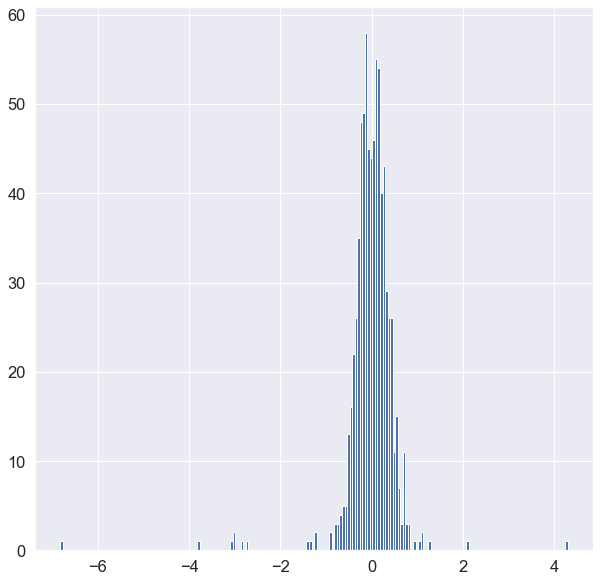

In [170]:
vec = word_embeddings[0][0]
vec = vec.detach().numpy()
# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

### Word Vectors

In [171]:
token_vecs = []
# For each token in the sentence...
for embedding in word_embeddings[0]:
    cat_vec = embedding.detach().numpy()
    # Use `cat_vec` to represent `token`.
    token_vecs.append(cat_vec)

In [172]:
token_vecs

[array([-1.36405915e-01, -1.71909511e-01, -5.03224134e-01, -6.79885074e-02,
        -1.41303256e-01,  1.60589680e-01,  2.72677571e-01,  2.89388031e-01,
         1.22623064e-01,  1.42307729e-01,  3.42316702e-02, -1.55974567e-01,
         1.25711441e-01,  5.26151597e-01,  4.95153755e-01, -1.39235377e-01,
        -7.15374425e-02,  3.93788159e-01,  3.57978344e-01, -3.17921698e-01,
        -2.67765552e-01, -1.11061521e-02,  1.27525523e-01,  3.32482934e-01,
         9.44417864e-02, -1.95288345e-01,  3.57750207e-01, -2.53607243e-01,
        -1.72836363e-01,  2.65141398e-01,  3.26615155e-01,  2.55470842e-01,
        -2.37761974e-01, -1.85585290e-01,  5.27833819e-01,  6.72465339e-02,
         1.00800842e-01,  1.79054603e-01, -7.74170905e-02, -2.68901885e-01,
        -2.33660445e-01,  2.49135464e-01, -6.66624308e-02,  5.67215025e-01,
        -1.58283740e-01, -1.98268250e-01, -3.04986501e+00, -1.29287511e-01,
         8.02916288e-02, -1.00337192e-01,  2.39671126e-01, -4.11712170e-01,
         3.6

### Sentence Vector

In [173]:
sentence_embedding_0 = sentence_embedding.detach().numpy()[0]

In [174]:
sentence_embedding_1 = np.mean(token_vecs, axis=0)

In [175]:
len(sentence_embedding_0), len(sentence_embedding_1)

(768, 768)

In [176]:
for i, token_str in enumerate(tokenized_text):
    print(i, token_str)

0 [CLS]
1 she
2 was
3 an
4 economic
5 refugee
6 from
7 a
8 neighboring
9 country
10 ,
11 an
12 '
13 illegal
14 '
15 unable
16 to
17 access
18 any
19 welfare
20 benefit
21 ,
22 existing
23 in
24 desperate
25 poverty
26 .
27 [SEP]


In [177]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity 
refugee_illegal = 1 - cosine(token_vecs[5], token_vecs[13])
refugee_poverty = 1 - cosine(token_vecs[5], token_vecs[25])

print('Vector similarity for  refugee-illegal  meanings:  %.2f' % refugee_illegal)
print('Vector similarity for refugee-poverty meanings:  %.2f' % refugee_poverty)

Vector similarity for  refugee-illegal  meanings:  0.69
Vector similarity for refugee-poverty meanings:  0.63


### Sentiment Analysis

In [32]:
from transformers import pipeline

In [33]:
# Allocate a pipeline for sentiment-analysis
nlp_sentiment = pipeline('sentiment-analysis')

In [34]:
df.head()

,sentence,label,year
0,""" bums . "" that 's what radio havana called ...",MAG,1990
1,section : investing expanding petrochemical ...,MAG,1990
2,section : clothes that work american history ...,MAG,1990
3,section : movements from socialist to republi...,MAG,1990
4,inside a dusty cement-block house with worn ...,MAG,1990


In [182]:
# sentiment analysis on the first article
nlp_sentiment(df.sentence[0])

[{'label': 'NEGATIVE', 'score': 0.9613159}]

In [184]:
for i in range(50):
    print(i, nlp_sentiment(df.sentence[i]))

0 [{'label': 'NEGATIVE', 'score': 0.9613159}]
1 [{'label': 'POSITIVE', 'score': 0.9970292}]
2 [{'label': 'NEGATIVE', 'score': 0.75497}]
3 [{'label': 'NEGATIVE', 'score': 0.9916307}]
4 [{'label': 'NEGATIVE', 'score': 0.97885484}]
5 [{'label': 'POSITIVE', 'score': 0.9847009}]
6 [{'label': 'NEGATIVE', 'score': 0.98906624}]
7 [{'label': 'POSITIVE', 'score': 0.8767313}]
8 [{'label': 'NEGATIVE', 'score': 0.994049}]
9 [{'label': 'POSITIVE', 'score': 0.99890333}]
10 [{'label': 'NEGATIVE', 'score': 0.9917997}]
11 [{'label': 'NEGATIVE', 'score': 0.969884}]
12 [{'label': 'POSITIVE', 'score': 0.86651057}]
13 [{'label': 'POSITIVE', 'score': 0.65408957}]
14 [{'label': 'NEGATIVE', 'score': 0.99771535}]
15 [{'label': 'NEGATIVE', 'score': 0.9956569}]
16 [{'label': 'POSITIVE', 'score': 0.9662176}]
17 [{'label': 'NEGATIVE', 'score': 0.9964287}]
18 [{'label': 'NEGATIVE', 'score': 0.9941967}]
19 [{'label': 'NEGATIVE', 'score': 0.99742407}]
20 [{'label': 'NEGATIVE', 'score': 0.9955175}]
21 [{'label': 'NEGAT

In [109]:
# negative - 0.9613159
df.sentence[0]

'  " bums . " that \'s what radio havana called them . and indeed , some of the 125,000 cubans who fled to the u.s. 10 years ago were thugs and hoodlums . but not photojournalist eduardo suarez . his is a classic american success story , even though his finances are a little out of focus .  the date : may 22 , 1980 . the place the dingy industrial port of mariel , 27 miles west of havana . the time early evening . there on the docks under a cloudless , moonlit sky stood television cameraman eduardo suarez , 30 , his bride of seven months , betty , 22 , and her 55-year-old mother rosa . taking advantage of castro \'s temporary liberalization of cuba \'s emigration policy , they had come to mariel to embark on a life of freedom . in just 18 hours , that new life would begin as it has for millions of immigrants in america , at the bottom of the social and economic ladder .  slowly they filed onto a 50-foot shrimp boat named           about 25 people . that night it sat low in the water , 

This article is about eduardo suarez's documentary of the mariel refugees. It contains many descriptions of the negative experiences of the cuban mariel refugees that likely contributed to the high negative score.

In [108]:
# positive - 0.9970292
df.sentence[1]

' section : investing  expanding petrochemical plants around houston will keep business growing for the kirby corp. , whose dixie carriers subsidiary is a top barge operation  some places are hot while others are not . here are six regions where savvy investors will make money in the 1990s .  look northwest , young investor . let \'s say that three years ago , you wisely saw a bonfire building in exports from oregon and washington , sparked by strong airliner and timber sales to europe and the far east . so you bought shares in the composite northwest 50 index , a mutual fund that holds stocks tied to that region \'s economy . since then , while few money managers have beaten the overall stock market , you and your fund have prospered : composite northwest scored a total return of 55.7% , nearly 11/2 times better than standard &; poor \'s 500 .  the moral of this tale : in the eight years since the last national recession , a pattern of powerful regional business cycles has taken shape

This article focuses alot on the economy, jobs and revenue. Likely sounding more positive with the words used of 'growing', 'opportunities' in contrast to the earlier snipper. However, it is likely that this algorithm works better on short sentences rather than long articles.

Overall, we can see from the BERT sentiment analysis that the articles containing refugee in the COCA corpus are overwhelmingly negative, although it is unclear if this algorithm works well for large amounts of text. This is actually pretty expected since the situations experienced by refugees tend to be negative. However, we can also use this to quantify and highlight the imbalance between positive vs negative articles on refugees and how this biases to seeing their needs and problems rather than their strengths and perserverance.

## Text Generation using BERT

The last method which we will explore is text generation. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, such as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.

These models can be quite impressive, even uncanny in how human like they sound. Check out this [cool website](https://transformer.huggingface.co), which allows you to write with a transformer. The website is built by the folks who wrote the package we are using. The code underneath the website can be found in their examples: [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py).

We will be using the built in generate function, but the example file has more detailed code which allows you to set the seed differently.

In [47]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

In [48]:
sequence = "Nothing that we like to do more than analyse data all day long and"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Nothing that we like to do more than analyse data all day long and then try to figure out what's going on.

"We're not going to be able to do that. We're not going to be able to do that.!


Wow. A little creepy, and as we can see, far from perfect: GPT doesn't alwats work out flawlessly, but it sometimes can, and we will try and see if fine-tuning helps. We are going to tune the model on a complete dataset of Trump tweets, as they have a set of distinctive, highly identifiable qualities.

### Creating a domain-specific language model

One of the most exciting things about BERT and GPT is being able to retune them the way we want to. We will be training models to perform two tasks - one is to create a BERT with an "accent", by traning a model with english news data from the UK, from the US, and from India. We will also train a language generation model with a bunch of Trump tweets. 

We can train models specifically over a certain domain to make its language generation similar to that domain. 
[run_language modelling.py](https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py), followed by [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py). I've downloaded these files and added them to this directory so we can run them through the notebook. You are encouraged to look at these files to get a rough idea of what is going on.

This [Google Colab file](https://colab.research.google.com/drive/1_G6iGqiXb-zPBTurRxd7cgGrXyNaKGsA) walks you through the process of fine-tuning models. Once you downloaded all the models and their information, place those files in the directory of the HW to use them as demonstrated below. 

### Loading Data 

We want to now get our Trump tweets and our English news datasets ready. The data the scripts expect is just a text file with relevant data. We load the Trump tweets and then write them to disk as train and test files with only data. I leave the original dataframes in case you would like to use it for your own purposes.

In [17]:
dfs = []

In [18]:
for file in os.listdir("../data/trump_tweets"):
    dfs.append(pd.read_json("../data/trump_tweets/" + file))

In [19]:
df = pd.concat(dfs)

In [20]:
df.head()

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
0,Twitter for iPhone,947824196909961216,Will be leaving Florida for Washington (D.C.) ...,2018-01-01 13:37:52+00:00,8237,NaN,51473,False
1,Twitter for iPhone,947810806430826496,Iran is failing at every level despite the ter...,2018-01-01 12:44:40+00:00,14595,25073877.0,53557,False
2,Twitter for iPhone,947802588174577664,The United States has foolishly given Pakistan...,2018-01-01 12:12:00+00:00,49566,NaN,138808,False
3,Twitter for iPhone,947614110082043904,HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...,2017-12-31 23:43:04+00:00,35164,NaN,154769,False
4,Twitter for iPhone,947592785519173632,As our Country rapidly grows stronger and smar...,2017-12-31 22:18:20+00:00,39428,NaN,157655,False


In [38]:
len(df)

3992

In [21]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df['text'], test_size=0.2)

In [22]:
train_text.head()

945     Attorney General Bill Schuette will be a fanta...
809     John Kasich should focus his special interest ...
190     I had to fire General Flynn because he lied to...
3199    "@bdean1468 @jlangdale @realDonaldTrump @Hilla...
714     "@JoshuaAlthina:I have a dream that one day I'...
Name: text, dtype: object

In [193]:
train_text.to_frame().to_csv(r'train_text_trump', header=None, index=None, sep=' ', mode='a')

In [194]:
test_text.to_frame().to_csv(r'test_text_trump', header=None, index=None, sep=' ', mode='a')

I now used the Google Colab GPUs to train the Trump tweet models. We'll be doing the same for our blog posts too.

### GloWBe dataset

We'll now load up the GloWbe (Corpus of Global Web-Based English) dataset which have different texts from different countries. We'll try and draw out texts from only the US, UK and India. We'll then save these to disk. Note that this is a Davies Corpora dataset: the full download can be done with the Dropbox link I sent in an announcement a few weeks ago. The whole download is about 3.5 GB but we only need two files, which are anout 250 MB each. The other files might be useful for your research purposes.

In [1]:
import lucem_illud_2020

In [3]:
address = "../../Project/Data/Davies Corpora/GloWbE"

In [4]:
# these are the exact name of the files
us = "/text_us_blog_jfy.zip"
gb = "/text_gb_blog_akq.zip"

In [5]:
us_texts = lucem_illud_2020.loadDavies(address, corpus_style="us_blog", num_files=5000)

text_us_blog_jfy.zip


In [6]:
gb_texts = lucem_illud_2020.loadDavies(address, corpus_style="gb_blog", num_files=5000)

text_gb_blog_akq.zip


We now have a dictionary with document ids mapping to text. Since we don't need any information but the text, we can just save these to disk.

In [7]:
' '.join(list(us_texts.values())[10])

"< h > Look how men 's and women 's magazines write about money < p > I read Oprah 's magazine once in a while Yes I said it And my jaw drops when I see an article like the recent 25 things you do n't have to worry about What Why do I need a magazine to tell me what I do n't need to worry about < p > But I 'm not the target audience It turns out men and women 's magazines are very different in the way they present money Whether that 's good or bad is the subject of a guest post by Nina Smith from Queercents I love how she 's used excerpts to point out the differences in how men 's and women 's magazines write about money < p > -Ramit < p > < p > Investment advice comes in all shapes and sizes Grab a few back issues of Esquire and a quick scan of its investing columns reveals investing advice For example they give the Baby Bells vs Cable Companies < p > So here 's my Aha moment why do men get investing advice in their magazines and we get financial basics in ours < p > Women get touchy 

In [13]:
def dict_to_texts(texts, file_name):
    text = []
    for doc in list(texts.values()):
        text.append(' '.join(doc).replace("< h >", "").replace("< p >", ""))
    train_text, test_text = train_test_split(text, test_size=0.2)
    with open(file_name + "_train", 'w') as f:
        for item in train_text:
            f.write("%s\n" % item)
    
    with open(file_name + "_test", 'w') as f:
        for item in test_text:
            f.write("%s\n" % item)

In [14]:
dict_to_texts(us_texts, "us_blog")

In [15]:
dict_to_texts(gb_texts, "gb_blog")

We now have the training and testing files for both US and GB blogs in English. 

### Running Scripts

We use the scripts to do language modelling and text generation. The following cells run the code as if you would have run it in a terminal. I trained all of these models using the Googlr Colab file, and then saved the models to disk.

#### Trump GPT-2

In [ ]:
# !python run_language_modelling.py --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump

#### RoBERTa US

In [ ]:
# !python run_language_modeling.py --output_dir=output_roberta_US --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=$TRAIN_FILE --do_eval --eval_data_file=$TEST_FILE --mlm

#### RoBERTa UK

In [ ]:
# !python run_language_modeling.py --output_dir=output_roberta_UK --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=$TRAIN_FILE --do_eval --eval_data_file=$TEST_FILE --mlm

### Loading and using models

Let us now load the four models we have and see how we can use them.

And now - let us see what our Trump Tweet Bot looks like!
You can generate text via command line using the command below. You can also load a model once it is saved - I trained my model using Google Colab, downloaded the model, and am loading it again via the command below. Note that you have to download all the files in your folder of the fine-tuned model to use the model.

In [ ]:
# !python run_generation.py --model_type=gpt2 --model_name_or_path=output_trump_gpt

In [73]:
tokenizer_trump = AutoTokenizer.from_pretrained("output_gpt_trump")
model_trump = AutoModelWithLMHead.from_pretrained("output_gpt_trump")

In [75]:
sequence = "Obama is going to"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Obama is going to be a disaster for the United States. He is a total loser!"
"""@jimmy_kirk: @realDonaldTrump @realDonaldTrump @foxandfriends @megynkelly @megynkelly @megyn"


Wow - our Trump bot is nasty, so we know our model trained well. What happens if we try the same sentence for our non-fine tuned model?

In [76]:
sequence = "Obama is going to"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Obama is going to be a very good president," said Sen. John McCain (R-Ariz.). "He's going to be a very good president. He's going to be a very good president. He's going to be a very"


Quite the contrast.

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that generate a BERT-powered chatbot tuned on text related to your final project. What is interesting about this model, and how to does it compare to an untrained model? What does it reveal about the social game involved with your dataset?

In [102]:
df_small = df_raw.sample(100)
df_small

,text_id,text,word_count,year,genre,subgen,source,title,publication_info
335,2031360,"after seven years of brutal conflict , liberi...",5011,1998,MAG,127.0,USCatholic,Jesus come! Devil go!,"Vol. 63, Iss. 12; pg. 26, 9 pgs\r\n"
928,239486,!mr-lehrer : good evening . leading the news ...,9170,1991,SPOK,107.0,PBS_Newshour,Kuwait Justice;New Blood,NaN
1682,153985,"4:00-5:00 pm , this is day to day . i 'm alex...",591,2003,SPOK,108.0,NPR_Daybreak,Interview: Reverend John Kirkley on comments m...,NaN
3446,4115348,insights into the minds of westerners who hav...,1152,2012,NEWS,135.0,CSMonitor,American jihadi in Somalia writes an autobiogr...,\r\n
2400,3053291,united nations -- after one month of tribal ...,1216,1994,NEWS,135.0,Houston,"""This eerie calm;; The Rwanda situation confou...",A; Pg. 8\r\n
...,...,...,...,...,...,...,...,...,...
2562,3003330,"nearly six decades have passed , but when sh...",2727,1997,NEWS,136.0,NYTimes,A Japanese Generation Haunted by Its Past,NaN
3039,3039475,"for the past month , halima ali 's home has ...",2210,2004,NEWS,135.0,WashPost,"<B>For</B> a Small Girl in Darfur, A Year of F...",\r\n
1663,120197,"11:00 am-12:00 noon , no year is complete wit...",663,2003,SPOK,108.0,NPR_Morning,"Review: Bruce Willis movie ""Tears of the Sun""",NaN
3200,3066761,uthman hassan is relieved to live in a city ...,1148,2007,NEWS,135.0,CSMonitor,"More Iraqis go north, fleeing violence;",WORLD; Pg. 4\r\n


In [103]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df_small['text'], test_size=0.2)

In [104]:
train_text.head()

3991     !lee-cowan# this morning , spiritual leaders ...
751      a little-known trove of images offers a fresh...
2915      iraq 's parliament unanimously recommended r...
184      i do n't think i 've spent good money on a ch...
3664     a boat of 153 sri lankan asylum seekers remai...
Name: text, dtype: object

In [105]:
train_text.to_frame().to_csv(r'train_coca_refugee', header=None, index=None, sep=' ', mode='a')

In [106]:
test_text.to_frame().to_csv(r'test_coca_refugee', header=None, index=None, sep=' ', mode='a')

In [235]:
## Trained language modelling
tokenizer_refugee = AutoTokenizer.from_pretrained("output_gpt_refugee_1")
model_refugee = AutoModelWithLMHead.from_pretrained("output_gpt_refugee_1")

In [236]:
## Untrained
sequence = "Refugees are"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Refugees are not allowed to enter the country.

The government has said it will not allow refugees to enter the country.

The government has said it will not allow refugees to enter the country.

The government has said!


In [237]:
## Trained
sequence = "Refugees are"

input = tokenizer_refugee.encode(sequence, return_tensors="pt")
generated = model_refugee.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_refugee.decode(generated.tolist()[0])
print(resulting_string)

Refugees are fleeing the violence in their homeland, and the government is trying to help them, but the refugees are not getting the help they need. "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" """


In [238]:
## Untrained
sequence = "Cuban refugees"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Cuban refugees, who are now living in the United States, are being held in detention centers in the United States.

The United States has been accused of sending thousands of people to the Middle East and Africa to fight against the Islamic State!


In [239]:
## Trained
sequence = "Cuban refugees"

input = tokenizer_refugee.encode(sequence, return_tensors="pt")
generated = model_refugee.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_refugee.decode(generated.tolist()[0])
print(resulting_string)

Cuban refugees are now being held in a detention center in the capital of the capital, the capital of the north-eastern province of the capital of the north-eastern province of the capital of the north-eastern province of the"


In [240]:
## Untrained
sequence = "Syrian refugees"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Syrian refugees.

The Syrian government has been accused of using the refugees as human shields, and has been accused of using them as human shields in the past.

The UN refugee agency has said that the Syrian government has used the refugees!


In [241]:
## Trained
sequence = "Syrian refugees"

input = tokenizer_refugee.encode(sequence, return_tensors="pt")
generated = model_refugee.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_refugee.decode(generated.tolist()[0])
print(resulting_string)

Syrian refugees in the country, the government has said.

"


In [242]:
## Untrained
sequence = "Muslim refugees"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Muslim refugees.

"We are not going to allow them to come here," he said. "We are going to make sure that they are not allowed to come here."

The group has been in the country for more than a!


In [243]:
## Trained
sequence = "Muslim refugees"

input = tokenizer_refugee.encode(sequence, return_tensors="pt")
generated = model_refugee.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_refugee.decode(generated.tolist()[0])
print(resulting_string)

Muslim refugees, and the government has been accused of failing to protect them.

"


In [244]:
## Untrained
sequence = "Kenyan refugees"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Kenyan refugees, who are fleeing war and poverty, are being held in camps in the country's north.

The UN refugee agency said on Tuesday that more than 1,000 people had been held in camps in the north since the start!


In [245]:
## Trained
sequence = "Kenyan refugees"

input = tokenizer_refugee.encode(sequence, return_tensors="pt")
generated = model_refugee.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_refugee.decode(generated.tolist()[0])
print(resulting_string)

Kenyan refugees are being held in camps in the north-eastern city of Nairobi.

"


It is interesting to see how the refugees are represented negatively in the bert initial untrained model, where "refugees are not allowed", Cuban refugees are held in detention centres, and the negative sentiments toward muslim refugees. Kenyan refugees on the other hand are seen to be fleeing an undesirable situation. 

While some of the same sentiments are reflected also in the COCA refugee subset, there are notable differences. For example, the initial model generated sentences where to not allow muslim refugee in the country. In contrast, in the trained model, the government has been accused of failing to protect them. Similarly, the text generation for refugees as a whole also moved away from not allowing entry to "Refugees are fleeing the violence in their homeland, and the government is trying to help them, but the refugees are not getting the help they need."

This seems to suggest that perhaps the trained dataset has different attitudes toward refugees looking at them as an underserved population rather than a problem.

## Roberta Model

Let's now check out our UK and GB embeddings - how do you think the two models will differ? Maybe in the way different words relate to each other in the same sentence? 

In [1]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer

In [2]:
roberta_us_model_embedding = RobertaModel.from_pretrained('roberta_us')

In [3]:
roberta_us_tokenizer = RobertaTokenizer.from_pretrained('roberta_us')

Let us try to visualise how words in a sentence or different or similar to each other. We will try to construct sentences where words might mean different things in different countries - in the US, people might eat chips with salsa, but in the UK, chips are what Americans call french fries, and might eat it fried fish instead. 

In [4]:
text = "Do you have your chips with fish or with salsa?" 

In [285]:
text1 = "He went out in just his undershirt and pants." #pants are underwear in Britain; maybe closer to an undershirt
text2 = "His braces completed the outfit." #braces are suspenders (in Britain); maybe closer to an outfit
text3 = "Does your pencil have a rubber on it?" #rubber is an eraser in Britain); maybe closer to a pencil
text4 = "Was the bog closer to the forest or the house?" #bog is a toilen in Britain); maybe closer to a house
text5 = "Are you taking the trolley or the train to the grocery market" #trolley is a food carriage; possibly closer to a market

In [115]:
import seaborn as sns

In [116]:
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div)
    plt.show()

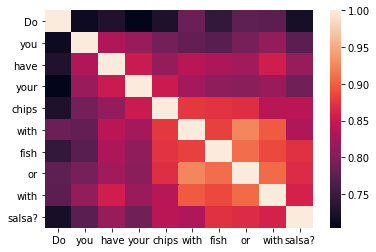

In [22]:
visualise_diffs(text, roberta_us_model_embedding, roberta_us_tokenizer)

In [23]:
roberta_gb_model_embedding = RobertaModel.from_pretrained('roberta_gb')
roberta_gb_tokenizer = RobertaTokenizer.from_pretrained('roberta_gb')

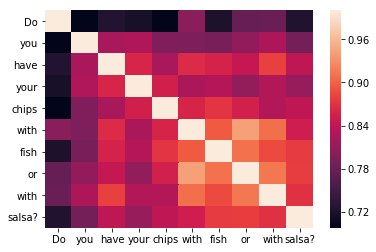

In [24]:
visualise_diffs(text, roberta_gb_model_embedding, roberta_gb_tokenizer)

What do you see regarding the relations with chips and sala/fish? What about the other sentences? How about comparing sentence embeddings?

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that tune BERT to at least two different textual samples. These could be from different corpora, distinct time periods, separate authors, alternative publishing outlets, etc. Then compare the meaning of words, phrases and sentences to each other across the separate models. What do they reveal about the social worlds inscribed by the distinctive samples?

In [94]:
coca_refugee_1990 = df_raw[df_raw.year == 1990]
coca_refugee_1990.head()

,text_id,text,word_count,year,genre,subgen,source,title,publication_info
0,2018849,""" bums . "" that 's what radio havana called ...",2950,1990,MAG,124.0,Money,This is the land of opportunity.,"Vol. 19 Issue 8, p98, 8p, 1 chart, 3c, 4bw\r\n"
1,2018850,section : investing expanding petrochemical ...,2514,1990,MAG,124.0,Money,Betting on regional booms.,"Vol. 19 Issue 8, p110, 5p, 1 chart, 2c\r\n"
2,2019006,section : clothes that work american history ...,1667,1990,MAG,130.0,MotherEarth,The evolution of jeans.,"p60, 4p, 5c, 2bw\r\n"
3,2019061,section : movements from socialist to republi...,1754,1990,MAG,123.0,MotherJones,Serve the people.,"Vol. 15 Issue 5, p18, 3p, 1 illustration\r\n"
4,2019063,inside a dusty cement-block house with worn ...,6032,1990,MAG,123.0,MotherJones,No road to Tahuanti.,"Vol. 15 Issue 5, p36, 11p, 8bw\r\n"


In [95]:
coca_refugee_2015 = df_raw[df_raw.year == 2015]
coca_refugee_2015.head()

,text_id,text,word_count,year,genre,subgen,source,title,publication_info
3737,4138779,a future worthy of our faith # the roman hist...,1936,2015,MAG,127.0,America,Building a Better Peace,"8/3/2015, Vol. 213 Issue 3, p15-18. 4p. 1 Colo..."
3738,4138793,the american evacuation from vietnam # it is ...,2582,2015,MAG,127.0,America,Return to Saigon,"4/27/2015, Vol. 212 Issue 14, p14-17. 4p. 1 Co..."
3739,4138810,toward a better understanding of religion and...,1628,2015,MAG,127.0,America,Religion and Diplomacy,"9/14/2015, Vol. 213 Issue 6, p14-16. 3p. 2 Col..."
3740,4138820,how pope francis focuses world attention on m...,1986,2015,MAG,127.0,America,The Migrant Pope,"7/6/2015, Vol. 213 Issue 1, p25-27. 3p. 1 Colo..."
3741,4138831,what we can do for middle east christians # f...,1257,2015,MAG,127.0,America,The Persecuted Church,"6/22/2015, Vol. 212 Issue 20, p19-21. 3p. 1 Co..."


In [96]:
from sklearn.model_selection import train_test_split
train_1990, test_1990 = train_test_split(coca_refugee_1990['text'], test_size=0.2)
train_2015, test_2015 = train_test_split(coca_refugee_2015['text'], test_size=0.2)

In [97]:
train_1990.head()

2057      diplomats and other analysts here said there...
2050      the soviet president urged bush to modify hi...
12        sure , the europeans protect their farmers a...
2026      rabbi gedaliah anamer , solemn-looking in bl...
2027      there are killers of all kinds here , and la...
Name: text, dtype: object

In [98]:
train_1990.to_frame().to_csv(r'train_refugee_1990', header=None, index=None, sep=' ', mode='a')

In [99]:
test_1990.to_frame().to_csv(r'test_refugee_1990', header=None, index=None, sep=' ', mode='a')

In [100]:
train_2015.to_frame().to_csv(r'train_refugee_2015', header=None, index=None, sep=' ', mode='a')

In [101]:
test_2015.to_frame().to_csv(r'test_refugee_2015', header=None, index=None, sep=' ', mode='a')

### Loading the Roberta Model

In [190]:
text = df_raw['text'][200][1450:1510]
text

'in gaza , an area packed with refugees and mired in poverty '

In [191]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer

In [192]:
refugee1990_model_embedding = RobertaModel.from_pretrained('output_refugee_1990')

In [193]:
refugee1990_tokenizer = RobertaTokenizer.from_pretrained('output_refugee_1990')

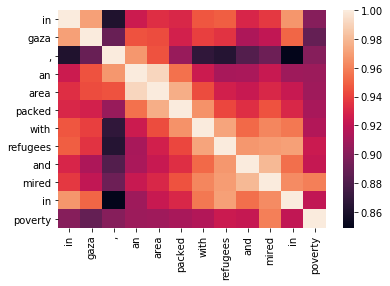

In [194]:
visualise_diffs(text, refugee1990_model_embedding, refugee1990_tokenizer)

In [195]:
refugee2015_model_embedding = RobertaModel.from_pretrained('output_refugee_2015')

In [196]:
refugee2015_tokenizer = RobertaTokenizer.from_pretrained('output_refugee_2015')

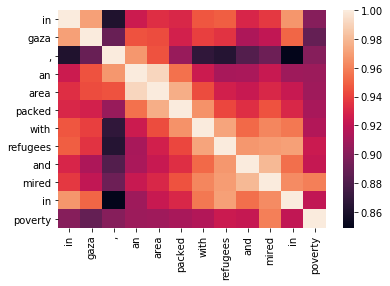

In [197]:
visualise_diffs(text, refugee2015_model_embedding, refugee2015_tokenizer)

In [227]:
text = df_raw['text'][123][13352:13430]
text

'a visit with somali refugees that helped energize president bush to authorize '

In [228]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer

In [229]:
refugee1990_model_embedding = RobertaModel.from_pretrained('output_refugee_1990')

In [230]:
refugee1990_tokenizer = RobertaTokenizer.from_pretrained('output_refugee_1990')

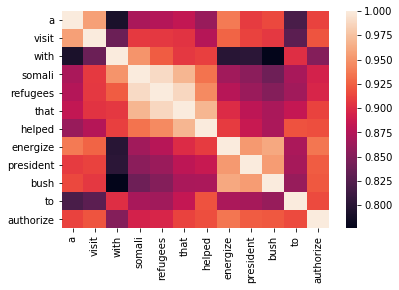

In [231]:
visualise_diffs(text, refugee1990_model_embedding, refugee1990_tokenizer)

In [232]:
refugee2015_model_embedding = RobertaModel.from_pretrained('output_refugee_2015')

In [233]:
refugee2015_tokenizer = RobertaTokenizer.from_pretrained('output_refugee_2015')

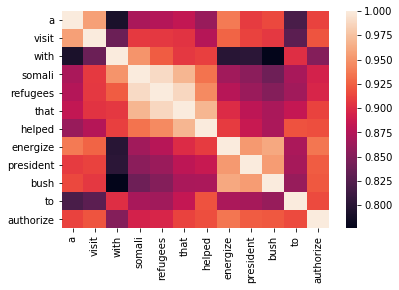

In [234]:
visualise_diffs(text, refugee2015_model_embedding, refugee2015_tokenizer)

Based on the two Roberta Models produced from refugee related articles in 1990 and 2015, there seems to be little change in meaning of the words for the text examined.